# Age-Metallicity Relation

In [1]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from scipy.stats import binned_statistic
from scipy.stats import gaussian_kde
from scipy.stats import median_abs_deviation as mad
import pandas as pd
from tqdm import tqdm

/u/fiza/conda-envs/auriga/lib/python3.7/site-packages/setuptools/_importlib.py:23: UserWarning: `importlib-metadata` version is incompatible with `setuptools`.
This problem is likely to be solved by installing an updated version of `importlib-metadata`.
  warnings.warn(msg)  # Ensure a descriptive message is shown.


In [2]:
from auriga.snapshot import Snapshot
from auriga.images import figure_setup, set_axs_configuration
from auriga.settings import Settings
from auriga.parser import parse

In [13]:
figure_setup()

In [4]:
settings = Settings()

In [5]:
N_RADIAL_BINS = 14
N_BINS_MAP = 200
MAP_VMIN, MAP_VMAX = 1E0, 1E3
AGE_RANGE = (0, 14)
ORIGINALS = [f"au{galaxy}_or_l4_s127" for galaxy in settings.galaxies]
RERUNS = [f"au{galaxy}_or_l4_s127" for galaxy in settings.reruns]

In [6]:
def read_data(simulation: str, include_region: bool = False,
              tag_in_situ: bool = False) -> pd.DataFrame:
    """
    This method returns data related to the analysis in this notebook.

    Parameters
    ----------
    simulation : str
        The simulation to consider.
    include_region : bool, optional
        If True, include the region tag in the output.

    Returns
    -------
    pd.DataFrame
        The properties in a Pandas DataFrame.
    """
    s = Snapshot(simulation=simulation,
                 loadonlytype=[0, 1, 2, 3, 4, 5])
    s.add_stellar_age()
    s.add_metal_abundance(of="Fe", to='H')
    s.add_circularity()

    is_real_star = (s.type == 4) & (s.stellar_formation_time > 0)
    is_main_obj = (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)

    props = {
        "StellarAge_Gyr": s.stellar_age[is_real_star & is_main_obj],
        "[Fe/H]": s.metal_abundance["Fe/H"][is_real_star & is_main_obj],
        "xPosition_ckpc": s.pos[is_real_star & is_main_obj, 0],
        "yPosition_ckpc": s.pos[is_real_star & is_main_obj, 1],
        "zPosition_ckpc": s.pos[is_real_star & is_main_obj, 2],}

    if include_region:
        s.tag_particles_by_region(
            disc_std_circ=settings.disc_std_circ,
            disc_min_circ=settings.disc_min_circ,
            cold_disc_delta_circ=settings.cold_disc_delta_circ,
            bulge_max_specific_energy=settings.bulge_max_specific_energy)
        props["ComponentTag"] = s.region_tag[is_real_star & is_main_obj]
        props["Circularity"] = s.circularity[is_real_star & is_main_obj]

    if tag_in_situ:
        s.tag_in_situ_stars()
        props["IsInSitu"] = s.is_in_situ[is_real_star & is_main_obj]

    return pd.DataFrame(props)

In [7]:
def get_stats_of_sample(simulations: list) -> pd.DataFrame:
    """
    This method returns the data of interest over the selected sample.

    Parameters
    ----------
    simulation : str
        The simulation to consider.

    Returns
    -------
    pd.DataFrame
        The properties in a Pandas DataFrame.
    """

    # Accumulate data for all galaxies
    ages = list()
    abundances = list()
    component_tags = list()

    for simulation in simulations:
        df = read_data(simulation, include_region=True)

        ages += list(df["StellarAge_Gyr"].to_numpy())
        abundances += list(df["[Fe/H]"].to_numpy())
        component_tags += list(df["ComponentTag"].to_numpy())

    ages = np.array(ages)
    abundances = np.array(abundances)
    component_tags = np.array(component_tags)

    median, bin_edges, _ = binned_statistic(
        x=ages,
        values=abundances,
        statistic=np.nanmedian,
        bins=N_RADIAL_BINS,
        range=AGE_RANGE
    )
    bin_centers = bin_edges[1:] - np.diff(bin_edges)[0] / 2

    stats = {"Median[Fe/H]": median,
             "AgeBinCenters_Gyr": bin_centers}
    
    # Add median por each component
    for i in range(len(settings.components)):
        median, _, _ = binned_statistic(
            x=ages[component_tags == i],
            values=abundances[component_tags == i],
            statistic=np.nanmedian,
            bins=N_RADIAL_BINS,
            range=AGE_RANGE)
        stats[f"Median[Fe/H]_{settings.components[i]}"] = median

    return pd.DataFrame(stats)

### Median Age-Metallicity Relation for Sample

In [78]:
stats = get_stats_of_sample(simulations=ORIGINALS)

### Age-Metallicity for Sample

In [8]:
SAMPLE = ORIGINALS
FIGURE_NAME = "originals"

In [93]:
fig = plt.figure(figsize=(7.2, 7.2))
gs = fig.add_gridspec(nrows=6, ncols=5, hspace=0.0, wspace=0.0)
axs = gs.subplots(sharex=True, sharey=True)

for ax in axs.flatten():
    ax.set_xlim(AGE_RANGE)
    ax.set_xticks([2, 4, 6, 8, 10, 12])
    ax.set_xlabel("Age [Gyr]")

    ax.set_ylim(-4, 3)
    ax.set_yticks([-3, -2, -1, 0, 1, 2])
    ax.set_ylabel("[Fe/H]")

    ax.tick_params(which="both", direction="in")
    ax.label_outer()
    
for i, simulation in enumerate(SAMPLE):
    ax = axs.flatten()[i]
    df = read_data(simulation=simulation)

    # Plot the map for this galaxy
    im = ax.hist2d(df["StellarAge_Gyr"],
                   df["[Fe/H]"],
                   cmap='nipy_spectral',
                   bins=N_BINS_MAP,
                   range=[ax.get_xlim(), ax.get_ylim()],
                   norm=mcolors.LogNorm(vmin=MAP_VMIN, vmax=MAP_VMAX),
                   rasterized=True)

    # Plot the median for this galaxy
    stat, bin_edges, _ = binned_statistic(
        x=df["StellarAge_Gyr"],
        values=df["[Fe/H]"],
        statistic=np.nanmedian,
        bins=N_RADIAL_BINS,
        range=AGE_RANGE)
    bin_centers = bin_edges[1:] - np.diff(bin_edges)[0] / 2
    ax.plot(bin_centers, stat)

    ax.text(x=0.05, y=0.95, s=r"$\texttt{" + simulation.upper() + "}$",
            size=6.0, transform=ax.transAxes, ha='left', va='top')

    # Plot the median for the sample and show the MSE
    ax.plot(stats["AgeBinCenters_Gyr"], stats["Median[Fe/H]"], c='k', ls="--")
    mse = ((stat - stats["Median[Fe/H]"])**2).sum() / stat.shape[0]
    ax.text(x=0.05, y=0.05,
            s=r"$\mathrm{MSE} = " + str(np.round(mse, 3)).ljust(5, '0') + "$",
            size=6.0, transform=ax.transAxes, ha='left', va='bottom')

    fig.savefig(f"../images/age_metallicity/{FIGURE_NAME}.pdf")

plt.close(fig)

### Age-Metallicity by Region for Galaxy

In [9]:
SIMULATION = "au6_or_l4_s127"

In [10]:
df = read_data(simulation=SIMULATION, include_region=True, tag_in_situ=True)

In [110]:
fig = plt.figure(figsize=(7.4, 2.0))
gs = fig.add_gridspec(nrows=1, ncols=4, hspace=0.0, wspace=0.0)
axs = gs.subplots(sharex=True, sharey=True)

for ax in axs.flat:
    ax.set_xlim(0, 14)
    ax.set_xticks([2, 4, 6, 8, 10, 12])
    ax.set_xlabel("Age [Gyr]")

    ax.set_ylim(-4, 3)
    ax.set_yticks([-3, -2, -1, 0, 1, 2])
    ax.set_ylabel("[Fe/H]")

    ax.tick_params(which='both', direction="in")
    ax.label_outer()

for i in range(len(settings.components)):
    is_region = (df["ComponentTag"] == i)

    im = axs[i].hist2d(
        df["StellarAge_Gyr"][is_region],
        df["[Fe/H]"][is_region],
        cmap='nipy_spectral', bins=N_BINS_MAP,
        range=[axs[i].get_xlim(), axs[i].get_ylim()],
        norm=mcolors.LogNorm(vmin=MAP_VMIN, vmax=MAP_VMAX),
        rasterized=True)[-1]

    axs[i].text(x=0.05, y=0.05, ha="left", va="bottom",
                s=settings.component_labels[settings.components[i]],
                size=8.0, transform=axs[i].transAxes)

    axs[i].plot(axs[i].get_xlim(),
                [np.nanmedian(df["[Fe/H]"][is_region]),
                 np.nanmedian(df["[Fe/H]"][is_region])],
                lw=.25, color='k')
    axs[i].plot([np.nanmedian(df["StellarAge_Gyr"][is_region]),
                 np.nanmedian(df["StellarAge_Gyr"][is_region])],
                axs[i].get_ylim(), lw=.25, color='k')
    axs[i].plot(np.nanmedian(df["StellarAge_Gyr"][is_region]),
                np.nanmedian(df["[Fe/H]"][is_region]),
                marker='o', mfc='k', ms=2, mew=0)

    # Median for this galaxy
    stat, bin_edges, _ = binned_statistic(
        x=df["StellarAge_Gyr"][is_region],
        values=df["[Fe/H]"][is_region],
        statistic=np.nanmedian,
        bins=N_RADIAL_BINS,
        range=AGE_RANGE)
    bin_centers = bin_edges[1:] - np.diff(bin_edges)[0] / 2
    axs[i].plot(bin_centers, stat, color="blue")

    # Median for the sample
    axs[i].plot(stats["AgeBinCenters_Gyr"],
                stats[f"Median[Fe/H]_{settings.components[i]}"],
                c="black", ls="--")

    # Calculate and write MSE
    mse = ((stat - stats[f"Median[Fe/H]_{settings.components[i]}"])**2).sum() \
        / stat.shape[0]
    axs[i].text(
        x=0.05, y=0.95,
        s="$\mathrm{MSE} = " + str(np.round(mse, 3)).ljust(5, '0') + "$",
        size=8.0, transform=axs[i].transAxes, ha="left", va="top",
        )

cbar = fig.colorbar(im, ax=axs[-1], orientation='vertical',
                    label=r'$N_\mathrm{stars}$',
                    pad=0)
cbar.ax.set_yticks([1E0, 1E1, 1E2, 1E3])

axs[0].text(x=axs[0].get_xlim()[0],
            y=axs[0].get_ylim()[1],
            s=r"$\texttt{" + simulation.upper() + "}$",
            size=8.0,
            ha='left', va='bottom',
            )

fig.savefig(f"../images/age_metallicity_by_region/{SIMULATION}.pdf")
plt.close(fig)

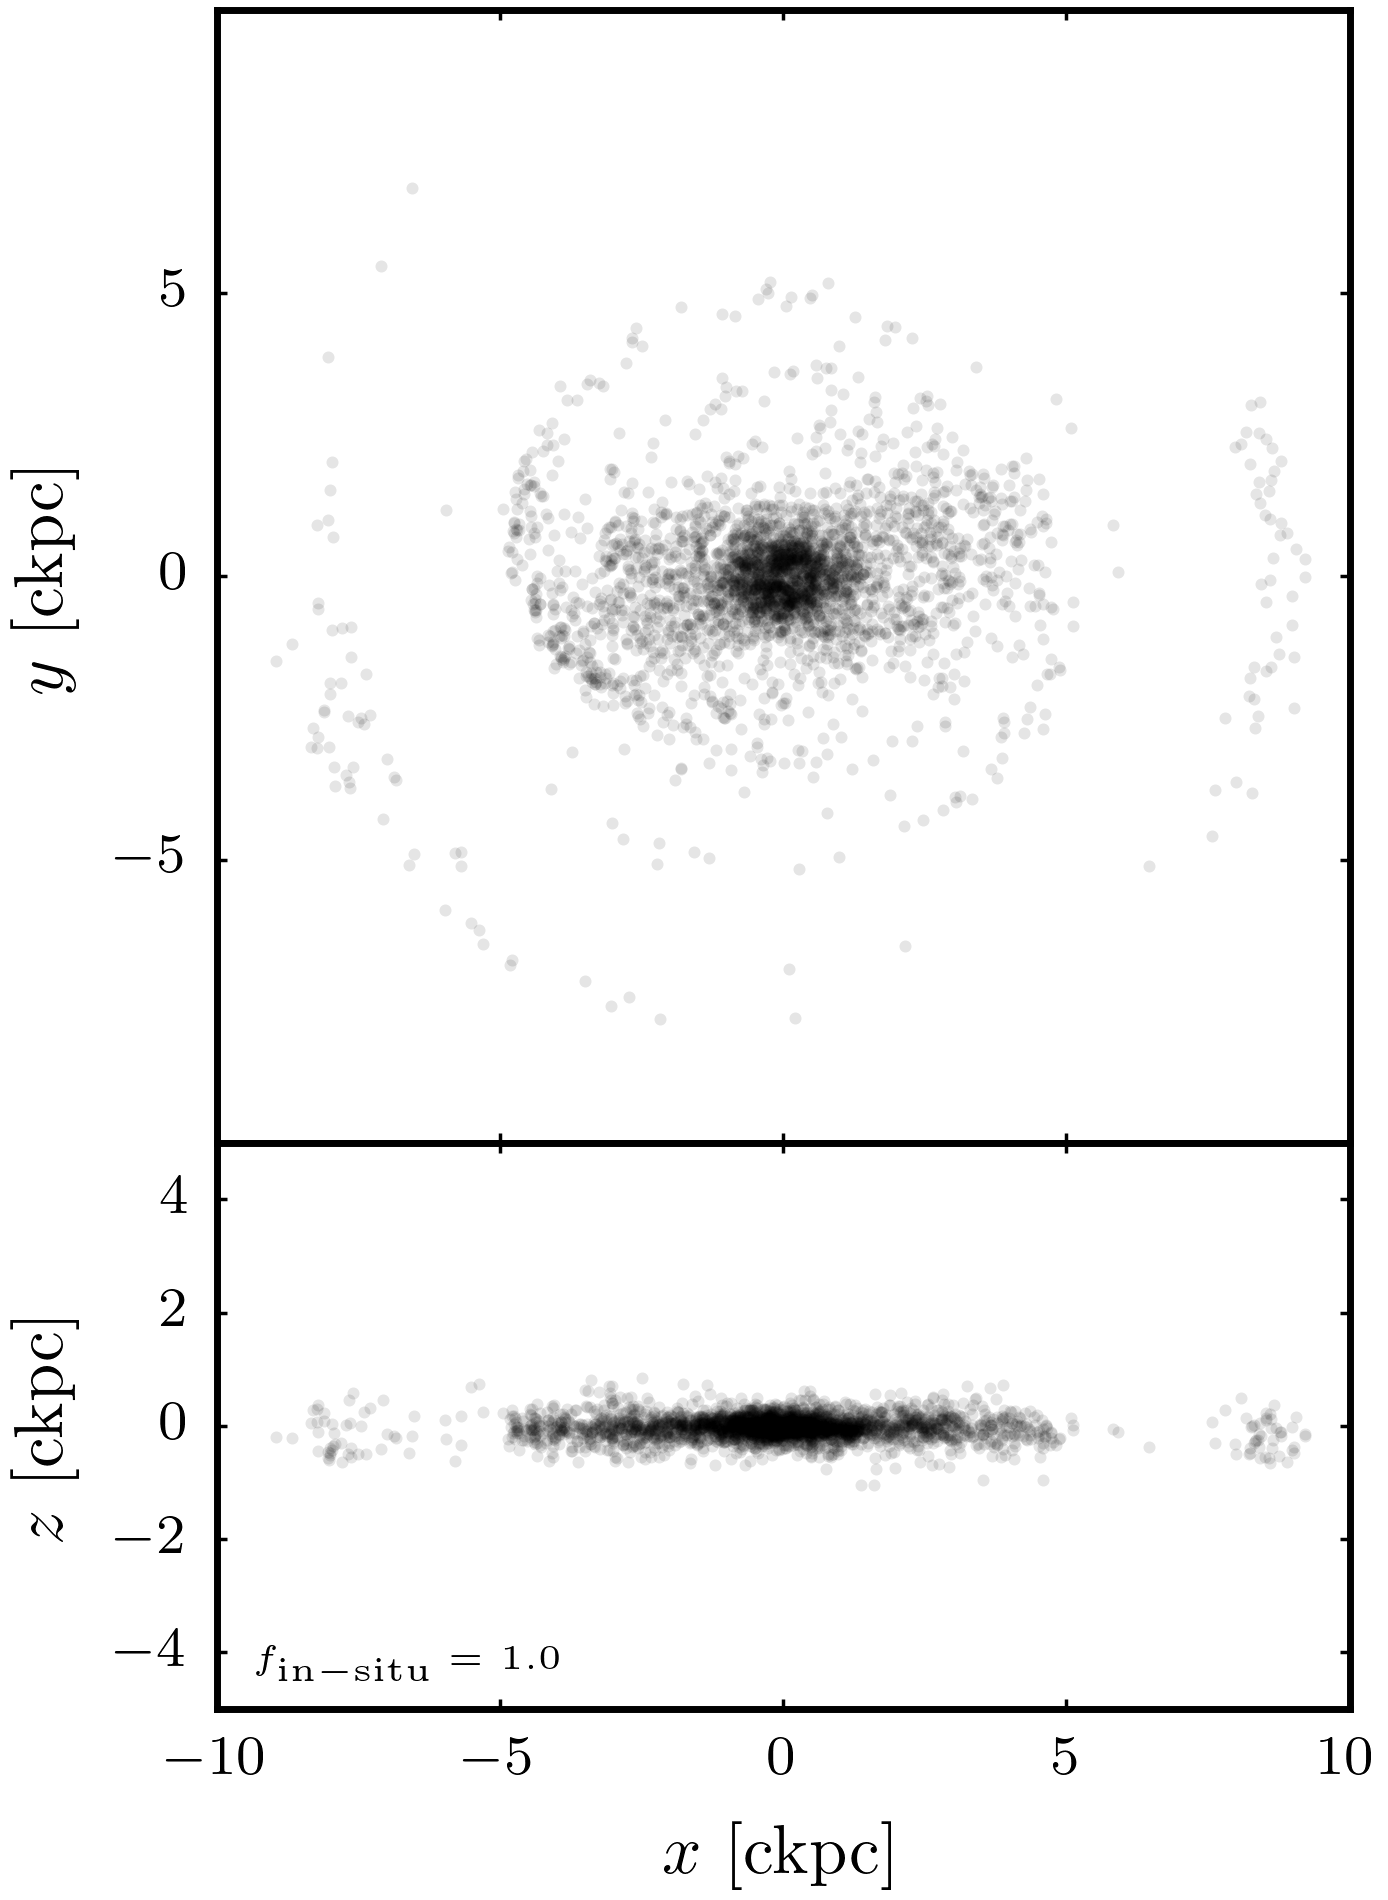

In [16]:
# Select particles in overdensity for the WM of Au6
AGE_MIN, AGE_MAX = 0, 2.5
ABUNDANCE_MIN, ABUNDANCE_MAX = 0.5, 1.3

is_overdensity = (df["StellarAge_Gyr"] <= AGE_MAX) \
    & (df["StellarAge_Gyr"] >= AGE_MIN) \
        & (df["[Fe/H]"] <= ABUNDANCE_MAX) \
            & (df["[Fe/H]"] >= ABUNDANCE_MIN) \
                & (df["ComponentTag"] == 3)
in_situ_fraction = (
    df["IsInSitu"][is_overdensity] == 1).sum() / is_overdensity.sum()

fig = plt.figure(figsize=(4.0, 4.0))
gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0.0, wspace=0.0)
axs = gs.subplots(sharex=True, sharey=False)
gs.set_height_ratios([2, 1])

axs[0].set_xlim(-10, 10)
axs[0].set_xlabel("")
axs[0].set_ylim(-10, 10)
axs[0].set_ylabel(r"$y$ [ckpc]")
axs[0].set_yticks([-5, 0, 5])
axs[0].set_aspect("equal")

axs[1].set_xlabel(r"$x$ [ckpc]")
axs[1].set_ylabel(r"$z$ [ckpc]")
axs[1].set_ylim(-5, 5)
axs[1].set_aspect("equal")

axs[0].scatter(df["xPosition_ckpc"][is_overdensity],
               df["yPosition_ckpc"][is_overdensity],
               alpha=0.1, lw=0, s=3, c="black")

axs[1].scatter(df["xPosition_ckpc"][is_overdensity],
               df["zPosition_ckpc"][is_overdensity],
               alpha=0.1, lw=0, s=3, c="black")
axs[1].text(0.035, 0.07, r"$f_\mathrm{in-situ}=$" + f" {in_situ_fraction}",
            transform=axs[1].transAxes, fontsize=5.0)

fig.tight_layout()
plt.show()

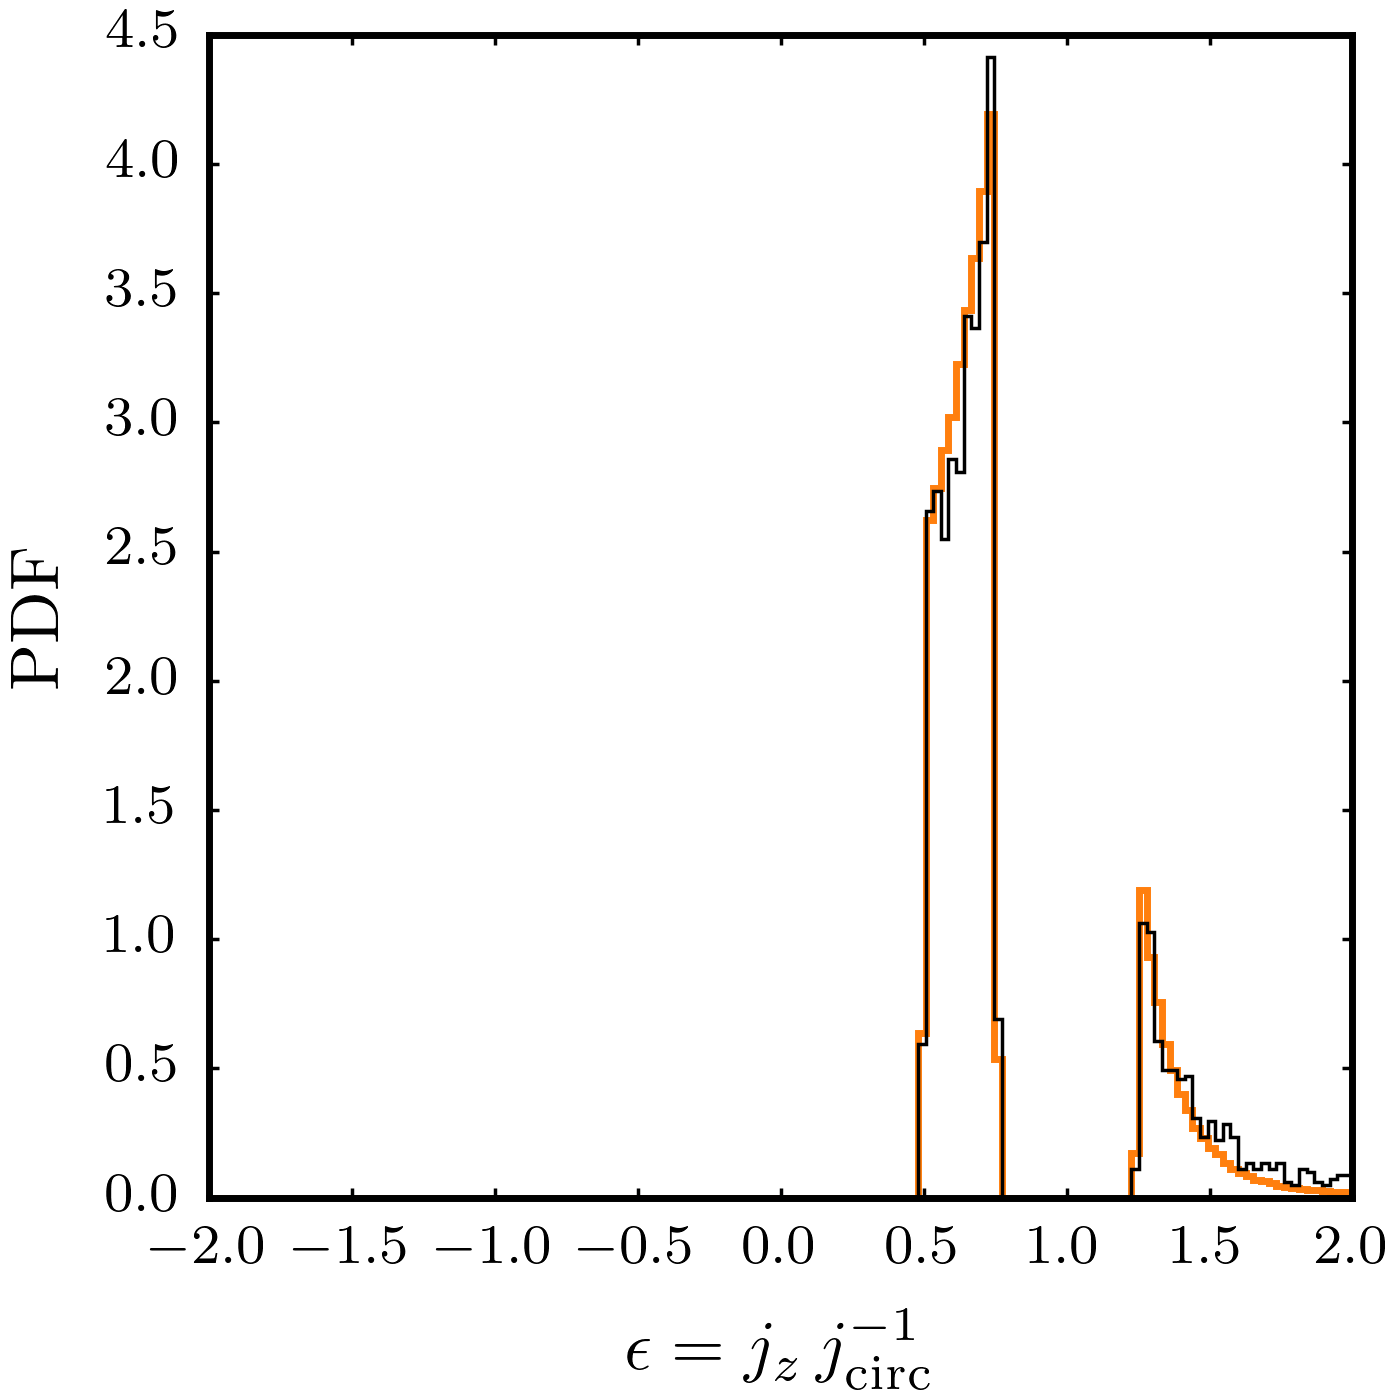

In [15]:
fig = plt.figure(figsize=(3.0, 3.0))
gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
ax = gs.subplots(sharex=True, sharey=False)

ax.set_xlim(-2, 2)
ax.set_xlabel(r"$\epsilon = j_z \, j_\mathrm{circ}^{-1}$")
ax.set_ylabel("PDF")

ax.hist(df["Circularity"][(df["ComponentTag"] == 3)],
        color="tab:orange", density=True, range=(-2, 2),
        bins=150, histtype="step")
ax.hist(df["Circularity"][is_overdensity],
        color="black", density=True, range=(-2, 2),
        bins=150, histtype="step", lw=0.5)

fig.tight_layout()
plt.show()

### Median Scatter

In [116]:
components = []
median_abundances = []
median_ages = []

for simulation in tqdm(ORIGINALS):
    df = read_data(simulation=simulation, include_region=True)
    for i in range(len(settings.components)):
        is_region = (df["ComponentTag"] == i)
        components.append(i)
        median_abundances.append(
            np.nanmedian(
                df["[Fe/H]"][is_region]))
        median_ages.append(
            np.nanmedian(
                df["StellarAge_Gyr"][is_region]))

components = np.array(components)
median_abundances = np.array(median_abundances)
median_ages = np.array(median_ages)

In [119]:
markers = ["o", "v", "^", "d"]
colors = list(settings.component_colors.values())
labels = list(settings.component_labels.values())

fig, axs = plt.subplots(
    figsize=(7.4, 2.0), nrows=1, ncols=4, sharey=True, sharex=True,
    gridspec_kw={"hspace": 0.0, "wspace": 0.0})

for ax in axs.flat:
    ax.grid(True, ls='-', lw=0.25, c="gainsboro")
    ax.tick_params(which='both', direction="in")

    ax.set_xlim(0, 14)
    ax.set_xticks([2, 4, 6, 8, 10, 12])
    ax.set_xlabel("median(Age) [Gyr]")

    ax.set_ylim(-1.0, 0.7)
    ax.set_ylabel('median([Fe/H])')
    ax.set_axisbelow(True)

    ax.label_outer()

for i, ax in enumerate(axs.flatten()):
    for j in range(4):
        label = labels[j] if j == i else None
        color = colors[j] if j == i else "silver"
        zorder = 10 if j == i else 5
        ax.scatter(
            median_ages[components == j],
            median_abundances[components == j],
            c=color, label=label, zorder=zorder,
            s=20, linewidths=0.4, edgecolors="white", marker=markers[j])

        if j == i:
            age_pdf = gaussian_kde(median_ages[components == j])
            pdf_x = np.linspace(0, 14, 100)
            pdf_y = age_pdf(pdf_x) / np.max(age_pdf(pdf_x)) * 0.2 - 1.0
            ax.fill_between(
                x=pdf_x, y1=-1.0, y2=pdf_y, edgecolor=color,
                facecolor=mcolors.TABLEAU_COLORS[color] + "30")
            
            abundance_pdf = gaussian_kde(median_abundances[components == j])
            pdf_y = np.linspace(-1.0, 0.7, 100)
            pdf_x = abundance_pdf(pdf_y) / np.max(abundance_pdf(pdf_y)) * 2
            ax.fill_betweenx(
                y=pdf_y, x1=-pdf_x + 14, x2=14, edgecolor=color,
                facecolor=mcolors.TABLEAU_COLORS[color] + "30")

    ax.legend(loc="upper left", framealpha=0, fontsize=7.5)

fig.savefig("../images/age_metallicity_by_region/median_scatter.pdf")
plt.close(fig)

### MSE Analysis

In [8]:
# df = pd.DataFrame()
# df["Galaxy"] = [f"Au{i}" for i in range(1, 31)]
# df["MSE"] = [0.033, 0.006, 0.019, 0.057, 0.004, 0.002, 0.061, 0.007, 0.012, 0.003, 0.043, 0.016, 0.009, 0.003, 0.099, 0.013, 0.039, 0.017, 0.032, 0.020, 0.009, 0.035, 0.010, 0.013, 0.006, 0.024, 0.007, 0.008, 0.034, 0.040]
# df["MSE_H"] = [0.035, 0.065, 0.062, 0.021, 0.033, 0.042, 0.038, 0.048, 0.073, 0.023, 0.017, 0.013, 0.013, 0.010, 0.081, 0.035, 0.068, 0.071, 0.029, 0.027, 0.016, 0.039, 0.073, 0.104, 0.062, 0.044, 0.056, 0.041, 0.062, 0.031]
# df["MSE_B"] = [0.019, 0.044, 0.020, 0.065, 0.016, 0.060, 0.054, 0.027, 0.004, 0.002, 0.048, 0.041, 0.002, 0.012, 0.167, 0.066, 0.028, 0.030, 0.057, 0.017, 0.026, 0.051, 0.014, 0.032, 0.024, 0.018, 0.032, 0.004, 0.025, 0.033]
# df["MSE_CD"] = [0.051, 0.006, 0.011, 0.039, 0.010, 0.002, 0.064, 0.011, 0.009, 0.002, 0.045, 0.017, 0.002, 0.007, 0.085, 0.005, 0.016, 0.017, 0.042, 0.026, 0.006, 0.015, 0.004, 0.008, 0.007, 0.012, 0.004, 0.004, 0.040, 0.015]
# df["MSE_WD"] = [0.053, 0.026, 0.032, 0.048, 0.014, 0.037, 0.076, 0.034, 0.017, 0.003, 0.047, 0.014, 0.004, 0.010, 0.106, 0.018, 0.024, 0.031, 0.053, 0.036, 0.010, 0.027, 0.041, 0.028, 0.022, 0.017, 0.029, 0.008, 0.026, 0.029]

In [49]:
# colors = np.array(["tab:blue"] * 30)
# colors[np.array(settings.groups["NotMilkyWayLike"]) - 1] = "tab:red"
# colors[np.array(settings.groups["Excluded"]) - 1] = "tab:gray"

In [68]:
# fig, axs = plt.subplots(figsize=(7.4, 2.0), ncols=4, 
#                         gridspec_kw={"wspace": 0.0})

# for ax in axs.flatten():
#     ax.set_xlim(0, 0.12)
#     ax.set_ylim(0, 0.12)
#     ax.set_xticks([0.02, 0.04, 0.06, 0.08, 0.10])
#     ax.set_xlabel(r"$\mathrm{MSE}$")
#     ax.grid(True, ls='-', lw=0.25, c='silver')
#     ax.set_ylabel(r"$\mathrm{MSE}_\mathrm{Component}$")
#     ax.label_outer()

# axs[0].scatter(df["MSE"], df[f"MSE_H"], zorder=10, c=colors, ls='-',
#                s=20, linewidths=0.5, edgecolors="white")
# axs[1].scatter(df["MSE"], df[f"MSE_B"], zorder=10, c=colors, ls='-',
#                s=20, linewidths=0.5, edgecolors="white")
# axs[2].scatter(df["MSE"], df[f"MSE_CD"], zorder=10, c=colors, ls='-',
#                s=20, linewidths=0.5, edgecolors="white")
# axs[3].scatter(df["MSE"], df[f"MSE_WD"], zorder=10, c=colors, ls='-',
#                s=20, linewidths=0.5, edgecolors="white")

# for i, comp in enumerate(settings.components):
#     axs[i].text(x=0.5, y=0.95,
#                 s=settings.component_labels[comp],
#                 size=8.0, transform=axs[i].transAxes,
#                 ha='center', va='top')

# fig.savefig(f"../images/age_metallicity_by_region/mse_analysis.pdf")
# plt.close(fig)